In [28]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.distributions.normal as dist

import time

latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

In [29]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [30]:
device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [31]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.fc_1 = nn.Linear(in_features=28*28, out_features=28*28)
        self.fc_2 = nn.Linear(in_features=28*28, out_features=28*28)
        self.fc_mu = nn.Linear(in_features=28*28, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=28*28, out_features=latent_dims)
        
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar
        
        
        
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.fc_1 = nn.Linear(in_features=latent_dims, out_features=28*28)
        self.fc_2 = nn.Linear(in_features=28*28, out_features=28*28)
        self.fc_3 = nn.Linear(in_features=28*28, out_features=28*28)
        
    def forward(self, x):
        x = F.relu(self.fc_1(x))
        x = F.relu(self.fc_2(x))
        x = F.sigmoid(self.fc_3(x))
        x = x.view(x.size(0), 28, 28)
        return x
        
        
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar) # reparemeterize
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
        
    #get_weight_samples from asg 2, however, here we just get one sample. Kinda strange no?
    def latent_sample(self, mu, logvar): 
        if self.training:
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu) # reparameterization trick
        else:
            return mu
        
def vae_loss(recon_x, x, mu, logvar):
    
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')
    
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + variational_beta * kl_div

vae = VariationalAutoencoder()
vae.to(device)

num_params = sum(p.numel() for p in vae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 2467252


In [33]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)
vae.train()
train_loss_avg = []


print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0
    
    
    for image_batch, _ in train_dataloader:
        image_batch = image_batch.to(device)
        
        image_batch_reconstruction, latent_mu, latent_logvar = vae(image_batch)
        loss = vae_loss(image_batch_reconstruction, image_batch, latent_mu, latent_logvar)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss_avg[-1] += loss.item()
        num_batches+=1
    train_loss_avg[-1] /= num_batches
    if (epoch % 10 == 0):
        print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 22869.053909
Epoch [11 / 100] average reconstruction error: 18021.345072
Epoch [21 / 100] average reconstruction error: 17611.867920
Epoch [31 / 100] average reconstruction error: 17351.886294
Epoch [41 / 100] average reconstruction error: 17209.695973
Epoch [51 / 100] average reconstruction error: 17060.111922
Epoch [61 / 100] average reconstruction error: 16992.655396
Epoch [71 / 100] average reconstruction error: 16936.640531
Epoch [81 / 100] average reconstruction error: 16870.894410
Epoch [91 / 100] average reconstruction error: 16789.032479


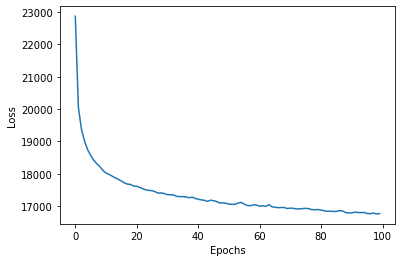

In [34]:
import matplotlib.pyplot as plt
plt.ion()

fig = plt.figure()
plt.plot(train_loss_avg)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation

In [35]:
# set to evaluation mode
vae.eval()

test_loss_avg, num_batches = 0, 0
for image_batch, _ in test_dataloader:
    
    with torch.no_grad():
    
        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        test_loss_avg += loss.item()
        num_batches += 1
    
test_loss_avg /= num_batches
print('average reconstruction error: %f' % (test_loss_avg))

average reconstruction error: 17150.542060


# Visualize

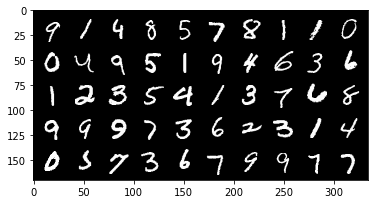

VAE reconstruction:
(140, 280)


In [60]:
plt.ion()

import torchvision.utils

vae.eval()

# This function takes as an input the images to reconstruct
# and the name of the model with which the reconstructions
# are performed

def gallery(images, ncols = 10):
    nindex, height, width = images.shape
    nrows = nindex//ncols
    assert nindex == nrows*ncols
    result = (images.reshape(nrows, ncols, height, width)
              .swapaxes(1,2)
              .reshape(height*nrows, width*ncols))
    return result

def to_img(x):
    x = x.clamp(0, 1)
    return x

def show_image(img):
    img = to_img(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def visualise_output(images, model):

    with torch.no_grad():
    
        images = images.to(device)
        images, _, _ = model(images)
        images = images.cpu()
        images = to_img(images)
        # plt.imshow(images[0])
        
        np_imagegrid = gallery( torchvision.utils.make_grid(images[1:51], 10, 5).numpy())
        plt.imshow(np_imagegrid, cmap="gray")
        plt.show()
        
        # plt.imshow(np.transpose(np_imagegrid, (1, 2, 0)))
        # plt.show()

images, labels = iter(test_dataloader).next()

# First visualise the original images
imgs = torchvision.utils.make_grid(images[1:51],10,5)
show_image(imgs)
plt.show()


# Reconstruct and visualise the images using the vae
print('VAE reconstruction:')
visualise_output(images, vae)